# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material is an extract and slight rewrite by Alan Edelman of a wonderful lecture by Steven Johnson at MIT: 
https://github.com/mitmath/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [2]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.34569261317643685
 0.1112134572415362
 0.4550929359353548
 0.17317640983364102
 0.4066803590702788
 0.07153916896884849
 0.14726519987545772
 0.5667997482708562
 0.41988237771680126
 0.5386979033285599
 0.3639693315973167
 0.8342289325651095
 0.829923127292524
 ⋮
 0.26534072444347845
 0.11201067505561446
 0.590109292029886
 0.5598866035923118
 0.2788348114289554
 0.9568162709654311
 0.8887933346353225
 0.04735644148969165
 0.8720596237977039
 0.48258355555715493
 0.8663077974019913
 0.3902671918473044

In [3]:
sum(a) # Remember 5,000,946 .5

5.0009465059590805e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

Julia has a `BenchmarkTools.jl` package for easy and accurate benchmarking:

In [4]:
using BenchmarkTools

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [5]:
using Libdl

In [41]:
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):


#open(`gcc  -fPIC -O3   -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
open(`gcc  -fPIC -O3 -ffast-math  -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [42]:
c_sum(a)

5.00094650595919e6

In [15]:
c_sum(a) - sum(a) # Compare the c_sum with the julia built in sum

-9.043142199516296e-7

In [16]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb  

true

In [10]:
≈  # alias for the `isapprox` function 

isapprox (generic function with 9 methods)

In [11]:
?isapprox

search: isapprox



```
isapprox(x, y; atol::Real=0, rtol::Real=atol>0 ? 0 : √eps, nans::Bool=false[, norm::Function])
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

The `norm` keyword defaults to `abs` for numeric `(x,y)` and to `LinearAlgebra.norm` for arrays (where an alternative `norm` choice is sometimes useful). When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

!!! compat "Julia 1.6"
    Passing the `norm` keyword argument when comparing numeric (non-array) arguments requires Julia 1.6 or later.


# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```

---

```
isapprox(x; kwargs...) / ≈(x; kwargs...)
```

Create a function that compares its argument to `x` using `≈`, i.e. a function equivalent to `y -> y ≈ x`.

The keyword arguments supported here are the same as those in the 2-argument `isapprox`.


We can now benchmark the C code directly from Julia:

In [43]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 1184 samples with 1 evaluation.
 Range (min … max):  3.539 ms …   8.817 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.913 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.210 ms ± 803.973 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂▇█▇▆▂▁                                                      
  █████████▅▆▆▅▅▅▄▃▃▃▃▃▄▃▃▃▃▃▃▃▃▂▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  3.54 ms         Histogram: frequency by time        7.42 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [44]:
c_bench.times  # m=miliseconds = 10^(-3)  μ=microseconds = 10^(-6)  n = nanoseconds = 10^(-9)

1184-element Vector{Float64}:
 4.060384e6
 3.911422e6
 3.807276e6
 4.265422e6
 3.714806e6
 6.519538e6
 3.702601e6
 3.874172e6
 3.772164e6
 3.815123e6
 3.907592e6
 4.796641e6
 3.879692e6
 ⋮
 3.640262e6
 3.714865e6
 4.156959e6
 3.719657e6
 3.683059e6
 3.991311e6
 4.827574e6
 7.50057e6
 3.854615e6
 3.630462e6
 3.709264e6
 3.842271e6

In [17]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec") 

C: Fastest time was 9.134485 msec


In [46]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 3.53866

In [19]:
using Plots
gr()

Plots.GRBackend()

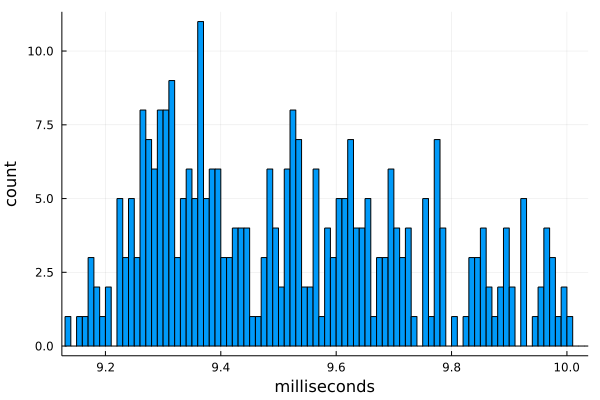

In [20]:
using Statistics

t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. Python's built in `sum`

The `PyCall` package provides a Julia interface to Python:

In [ ]:
#]add PyCall

In [25]:
using PyCall

In [26]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [27]:
pysum(a)

5.000946505958176e6

In [28]:
pysum(a) ≈ sum(a)

true

In [29]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.129 s …   1.160 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.134 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.140 s ± 12.454 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █       ██                █                             █  
  █▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.13 s         Histogram: frequency by time        1.16 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [49]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 3.53866
  "Python numpy"    => 3.62221
  "Python built-in" => 1129.02

# 3. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [ ]:
# using Pkg

In [ ]:
# Pkg.add("Conda")

In [31]:
using Conda 
#Conda.add("numpy")

In [32]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 1113 samples with 1 evaluation.
 Range (min … max):  3.622 ms …  11.659 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.217 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.481 ms ± 852.960 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁▄▅▇▅█▃▃▅▄▂▁▁  ▁                                             
  █████████████▇██▇▅▅▄▄▅▃▄▅▄▄▅▃▄▃▃▂▃▃▃▃▃▃▃▃▃▁▃▂▂▃▁▂▃▂▁▃▂▃▂▃▂▂ ▄
  3.62 ms         Histogram: frequency by time        7.34 ms <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [33]:
numpy_sum(a) 

5.000946505959081e6

In [34]:
numpy_sum(a) ≈ sum(a)

true

In [50]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 3.53866
  "Python numpy"    => 3.62221
  "Python built-in" => 1129.02

# 4. Python, hand-written

In [51]:
py"""
def py_sum(a):
    s = 0.0
    for x in a:
        s = s + x
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f85d0689a60>

In [52]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 4 samples with 1 evaluation.
 Range (min … max):  1.421 s …  1.439 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.431 s             ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.431 s ± 7.982 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                 █                        █           █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.42 s        Histogram: frequency by time        1.44 s <

 Memory estimate: 336 bytes, allocs estimate: 6.

In [53]:
sum_py(a)

5.000946505958176e6

In [54]:
sum_py(a) ≈ sum(a)

true

In [55]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"                   => 3.53866
  "Python numpy"        => 3.62221
  "Python hand-written" => 1421.27
  "Python built-in"     => 1129.02

# 5. Julia (built-in) 

## Written directly in Julia, not in C!

In [56]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:873

In [57]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 1182 samples with 1 evaluation.
 Range (min … max):  3.221 ms …   8.996 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.947 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.216 ms ± 910.231 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▄▆█▂▄▅▄▂▃▂▂                                                 
  ▆████████████▇█▆▇▇▆▆▄▄▅▄▃▄▅▃▃▃▄▃▃▃▃▃▃▂▁▃▂▂▃▃▃▃▃▁▂▂▂▂▁▂▂▂▂▂▂ ▄
  3.22 ms         Histogram: frequency by time        7.55 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [58]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 3.53866
  "Python numpy"        => 3.62221
  "Python hand-written" => 1421.27
  "Python built-in"     => 1129.02
  "Julia built-in"      => 3.22138

# 6. Julia (hand-written)

In [59]:
function mysum(A)   
    s = 0.0  # s = zero(eltype(A))
    #@inbounds @simd for a in A
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [60]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 489 samples with 1 evaluation.
 Range (min … max):   9.364 ms …  16.093 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):      9.879 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   10.206 ms ± 888.197 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▂█▆▄▁ ▁                                                       
  ███████▅▇▆▆▆▆▅▃▄▄▅▃▄▄▄▄▃▅▃▄▄▃▃▃▂▃▄▃▃▃▄▁▂▂▂▂▁▁▁▂▂▁▁▁▁▂▂▁▃▁▁▁▂ ▃
  9.36 ms         Histogram: frequency by time         13.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [61]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 3.53866
  "Python numpy"        => 3.62221
  "Julia hand-written"  => 9.36411
  "Python hand-written" => 1421.27
  "Python built-in"     => 1129.02
  "Julia built-in"      => 3.22138

 # 7. Julia hand-written ++

In [62]:
function myfastsum(A)   
    s = 0.0  # s = zero(eltype(A))
    @inbounds @simd for a in A  # <-- don't check bounds, parallel on processor
        s += a
    end
    s
end

myfastsum (generic function with 1 method)

In [63]:
j_bench_hand_pp = @benchmark myfastsum($a)

BenchmarkTools.Trial: 1279 samples with 1 evaluation.
 Range (min … max):  3.129 ms …   9.481 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     3.608 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   3.895 ms ± 872.639 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

   ▇█▇▆▃▄▂▁                                                    
  ▆█████████▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▃▂▃▃▃▃▂▂▃▂▂▂▂▃▃▂▂▂▂▂▂▁▂▁▂▁▂▂▂▂▂ ▃
  3.13 ms         Histogram: frequency by time         7.4 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [64]:
d["Julia hand-written-pp"] = minimum(j_bench_hand_pp.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "Julia hand-written-pp" => 3.12928
  "C"                     => 3.53866
  "Python numpy"          => 3.62221
  "Julia hand-written"    => 9.36411
  "Python hand-written"   => 1421.27
  "Python built-in"       => 1129.02
  "Julia built-in"        => 3.22138

# Summary

In [65]:
for (key, value) in sort(collect(d))
    println(rpad(key, 20, "."), lpad(round(value, digits=1), 8, "."))
end

C........................3.5
Julia built-in...........3.2
Julia hand-written.......9.4
Julia hand-written-pp.....3.1
Python built-in.......1129.0
Python hand-written...1421.3
Python numpy.............3.6


In [66]:
for (key, value) in sort(collect(d), by=x->x[2])
    println(rpad(key, 20, "."), lpad(round(value, digits=2), 10, "."))
end

Julia hand-written-pp......3.13
Julia built-in............3.22
C.........................3.54
Python numpy..............3.62
Julia hand-written........9.36
Python built-in........1129.02
Python hand-written....1421.27


In [78]:
n=10000
a = [rand(1,3) for i=1:n]
b = [rand(3) for i=1:n]
dist(x,y) = norm(x-y)
@time dist.(a',b)

  7.798401 seconds (100.15 M allocations: 11.183 GiB, 18.40% gc time, 0.41% compilation time)


10000×10000 Matrix{Float64}:
 0.609916  0.830623  0.352477  0.471699  …  0.341137  0.439457  0.77134
 0.5926    0.862986  0.843676  1.28757      1.07081   1.17544   0.458869
 0.995392  1.45762   0.761443  1.33356      1.1533    1.26886   0.888248
 0.642146  1.10293   0.377227  0.871646     0.711009  0.80364   0.624387
 0.665835  0.956227  0.628567  1.2238       0.978207  1.13792   0.59928
 0.764226  0.846185  0.536335  0.734385  …  0.580453  0.717387  0.918644
 0.804858  0.780216  0.708778  1.01339      0.815076  0.972177  0.92787
 0.592371  1.05186   0.506471  1.16228      0.929805  1.06903   0.443265
 0.564068  0.40676   0.617824  0.29558      0.237532  0.242405  0.822744
 0.339819  0.697582  0.199146  0.788659     0.545779  0.701709  0.419294
 0.743648  0.950966  0.454695  0.743786  …  0.590527  0.71837   0.861266
 0.514687  0.488768  0.597699  0.939471     0.711389  0.862495  0.639563
 0.714529  1.17353   0.463724  1.04677      0.858186  0.976374  0.649729
 ⋮                       

In [72]:
using LinearAlgebra